# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

We laid the foundations for this with streaming. 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user `approval`.

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1. 

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [33]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b


tools = [add, multiply, divide, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [34]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [35]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

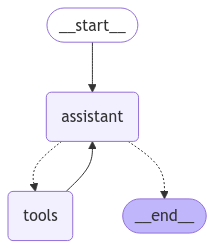

In [36]:
# Graph without interupts
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:
# Input
initial_input = {
    "messages": HumanMessage(content="Multiply 2 and 3 and then add 5 to the result.")
}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 5 to the result.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_R3VXHNNstaL2KN0UtO06cyJ3)
 Call ID: call_R3VXHNNstaL2KN0UtO06cyJ3
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  add (call_bKPQ9dRtxUpPUqR0uh28mySn)
 Call ID: call_bKPQ9dRtxUpPUqR0uh28mySn
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================

The result of multiplying 2 and 3 and then adding 5 is 11.


Now we add interupts to the graph at tool call

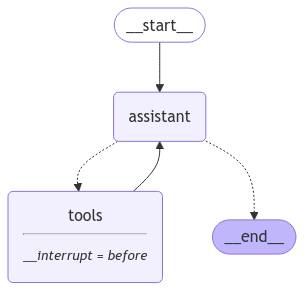

In [38]:
# new graph with interupts
builder = StateGraph(MessagesState)
# define the nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
# add feedback loop
builder.add_edge("tools", "assistant")

# compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
# Input
initial_input = {
    "messages": HumanMessage(content="Multiply 2 and 3 and then add 5 to the result.")
}

# Thread
thread = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and then add 5 to the result.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tzyhJYwRmAIDKy6PxSXbZ0q5)
 Call ID: call_tzyhJYwRmAIDKy6PxSXbZ0q5
  Args:
    a: 2
    b: 3


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [40]:
# what we see in next is the result of the tool call
state = graph.get_state(thread)
state.next

('tools',)

In [41]:
state.tasks

(PregelTask(id='d5b3d2a5-0944-5d54-f9d0-aefd7dd09fc6', name='tools', path=('__pregel_pull', 'tools'), error=None, interrupts=(), state=None, result=None),)

In [42]:
state.config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe769a-5828-6a09-8001-50d575b57e7f'}}

In [43]:
state.metadata

{'source': 'loop',
 'writes': {'assistant': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tzyhJYwRmAIDKy6PxSXbZ0q5', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 170, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ef27468-d2ca-437b-9db9-8717b7925165-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_tzyhJYwRmAIDKy6PxSXbZ0q5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 18, 'total_tokens': 188, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [44]:
state.values

{'messages': [HumanMessage(content='Multiply 2 and 3 and then add 5 to the result.', additional_kwargs={}, response_metadata={}, id='8c53976b-36fe-44f5-acfe-4860eeb9a897'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tzyhJYwRmAIDKy6PxSXbZ0q5', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 170, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ef27468-d2ca-437b-9db9-8717b7925165-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_tzyhJYwRmAIDKy6PxSXbZ0q5', 'type': 'tool_call'}], usage_metadata={'input

In [45]:
state.parent_config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe769a-4fc3-6b5e-8000-5e7051a5e33e'}}

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

So it interrupts before the tool call, and then we can approve the tool call.

In [46]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_tzyhJYwRmAIDKy6PxSXbZ0q5)
 Call ID: call_tzyhJYwRmAIDKy6PxSXbZ0q5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  add (call_pvPLMltWCNeI0eUFRi9ewYDI)
 Call ID: call_pvPLMltWCNeI0eUFRi9ewYDI
  Args:
    a: 6
    b: 5


In [47]:
# what we see in next is the result of the tool call
state = graph.get_state(thread)
state.next

('tools',)

In [48]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (call_pvPLMltWCNeI0eUFRi9ewYDI)
 Call ID: call_pvPLMltWCNeI0eUFRi9ewYDI
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================

The result of multiplying 2 and 3 and then adding 5 is 11.


In [49]:
# what we see in next is the result of the tool call
state = graph.get_state(thread)
state.next

()

So what we now do is make this dynamic so that it confirms everytime a tool is called. This is done by adding a feedback loop to the graph. The feedback loop will route the assistant back to the tools node after a tool has been called. This will allow the assistant to confirm the result of the tool call before continuing with the next step in the conversation.

In [50]:
from uuid import uuid4

# Get the human input.
user_query = input("Enter your calculation (or type 'exit' to quit): ")
if user_query.strip().lower() == "exit":
    exit()

# Prepare the initial input and thread configuration.
initial_input = {"messages": [HumanMessage(content=user_query)]}
thread = {"configurable": {"thread_id": str(uuid4())}}

# For the first iteration, we pass the human input.
# For subsequent iterations (pending tool calls), we'll pass None.
current_input = initial_input

# Single while loop: continue until no further tool call is indicated.
while True:
    # Stream the current input through the graph.
    for event in graph.stream(current_input, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

    # Retrieve the graph's current state.
    state = graph.get_state(thread)

    # If there is no pending tool call, exit the loop.
    if state.next != ("tools",):
        break

    # Ask the user for feedback about proceeding with the tool call.
    user_approval = input("Do you want to call the tool? (yes/no): ")
    if user_approval.lower() != "yes":
        print("User opted not to call the tool. Exiting.")
        break

    # Set current_input to None for processing the pending tool call.
    current_input = None

print("Finished processing the input.")

================================ Human Message =================================

add 6 and 6 then substract with 6 and then multiply with 6 and then dvide with 6
================================== Ai Message ==================================
Tool Calls:
  add (call_mlTACq9Y1FNA2kZIeJyD8Xxa)
 Call ID: call_mlTACq9Y1FNA2kZIeJyD8Xxa
  Args:
    a: 6
    b: 6
================================== Ai Message ==================================
Tool Calls:
  add (call_mlTACq9Y1FNA2kZIeJyD8Xxa)
 Call ID: call_mlTACq9Y1FNA2kZIeJyD8Xxa
  Args:
    a: 6
    b: 6
================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================
Tool Calls:
  subtract (call_MCkSbwoJjLhZgHhNVb3WClSo)
 Call ID: call_MCkSbwoJjLhZgHhNVb3WClSo
  Args:
    a: 12
    b: 6
================================== Ai Message ==================================
Tool Calls:
  subtract (call_MCkSbwoJjLhZgHhNVb3WClSo)
 Call ID:

####################################################### END ########################################################################